In [1]:
from PIL import Image
from PIL import ImageFile
import torch
import glob
import os
import platform
import zipfile
from zipfile import ZipFile
import json
import argparse
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.autograd import Variable
from functools import partial
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision

from Architectures.cGAN_net import Generator, Discriminator, weights_init
from ImageDataset import ImageDataset

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
dataset = ImageDataset('DATA')
dataset_info = {'classes': list(set(dataset.labels)), 'encoder': dataset.encoder, 'decoder': dataset.decoder, 'num_classes': dataset.num_classes, 'requires_label': True}

In [9]:
ngpu = 1
workers = 2
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
learning_rate = 1e-4
beta1 = 0.5
batch_size = 64
image_size = 64
img_ch = 3
z_dim = 100
num_epochs = 200
features_g = 64
features_d = 64

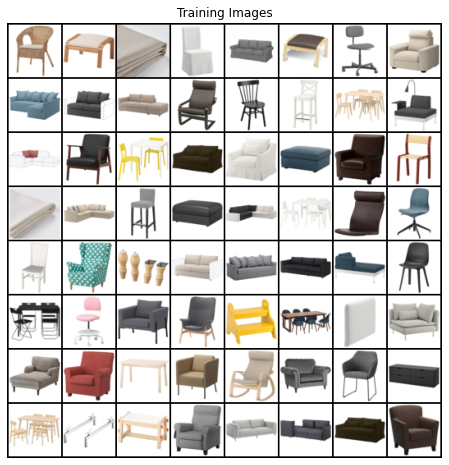

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
# Create the Generator and Discriminator
netG = Generator(ngpu, features_g, z_dim, img_ch, num_classes, embed_size).to(device)
netD = Discriminator(ngpu, features_d, img_ch, num_classes, img_size, embed_size).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    netG = nn.DataParallel(netG, list(range(ngpu)))


netD.apply(weights_init)
netG.apply(weights_init)
# Initialize BCELoss function
criterion = nn.BCELoss()


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [20]:
learning_rate = 0.0002
beta_1 = 0.5
batch_size = 32# 64]
os.makedirs('model/cGAN', exist_ok=True)
with open('model/cGAN/image_data.json', 'w') as f:
    json.dump(dataset_info, f) 

fixed_noise = Variable(torch.randn(batch_size, z_dim)).to(device)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True,num_workers=workers)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Number of training epochs
num_epochs = 20
suffix = f'lr={learning_rate}_beta={beta1}_batch={batch_size}' 
writer = SummaryWriter(log_dir=f'logs_runs/logs_cGAN/'
                    + f'{suffix}')
img_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, label) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        # Forward pass real batch through D
        output = netD(data.to(device), label.to(device)).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, Variable(torch.ones_like(output)).to(device))
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = Variable(torch.randn(batch_size, z_dim)).to(device)
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, dataset.num_classes, batch_size))).to(device)
        # Generate fake image batch with G
        fake = netG(noise, fake_labels)
        # label.fill_(fake_label)
        # Classify all fake batch with D
        
        output = netD(fake.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, Variable(torch.zeros_like(output)).to(device))
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake.detach(), fake_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, Variable(torch.ones_like(output)).to(device))
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 200 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_labels = Variable(torch.LongTensor(np.random.randint(0, dataset.num_classes, batch_size))).to(device)
                fake = netG(fixed_noise, fake_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    writer.add_scalar('Loss_Generator', errG.item(), epoch)
    writer.add_scalar('Loss_Discriminator', errD.item(), epoch)
    writer.add_scalar('D(x)', D_x, epoch)
    writer.add_scalar('D(G(z))', D_G_z2, epoch)
torch.save(netD, 'model/cGAN/Discriminator.pt')
torch.save(netG, 'model/cGAN/Generator.pt')

Starting Training Loop...
[0/20][0/85]	Loss_D: 1.7106	Loss_G: 1.7420	D(x): 0.4181	D(G(z)): 0.4276 / 0.1966
[0/20][10/85]	Loss_D: 0.0556	Loss_G: 4.4395	D(x): 0.9747	D(G(z)): 0.0262 / 0.0161
[0/20][20/85]	Loss_D: 0.0206	Loss_G: 5.1371	D(x): 0.9923	D(G(z)): 0.0126 / 0.0087
[0/20][30/85]	Loss_D: 0.0044	Loss_G: 6.3873	D(x): 0.9979	D(G(z)): 0.0023 / 0.0021
[0/20][40/85]	Loss_D: 0.0078	Loss_G: 6.1140	D(x): 0.9984	D(G(z)): 0.0062 / 0.0035
[0/20][50/85]	Loss_D: 0.0032	Loss_G: 6.7487	D(x): 0.9990	D(G(z)): 0.0022 / 0.0019
[0/20][60/85]	Loss_D: 0.0022	Loss_G: 7.0892	D(x): 0.9989	D(G(z)): 0.0012 / 0.0011
[0/20][70/85]	Loss_D: 0.0017	Loss_G: 7.3423	D(x): 0.9994	D(G(z)): 0.0011 / 0.0010
[0/20][80/85]	Loss_D: 0.0017	Loss_G: 7.5532	D(x): 0.9992	D(G(z)): 0.0009 / 0.0008
[1/20][0/85]	Loss_D: 0.0013	Loss_G: 7.3865	D(x): 0.9996	D(G(z)): 0.0009 / 0.0008
[1/20][10/85]	Loss_D: 0.0009	Loss_G: 7.6482	D(x): 0.9998	D(G(z)): 0.0007 / 0.0006
[1/20][20/85]	Loss_D: 0.0007	Loss_G: 8.0603	D(x): 0.9998	D(G(z)): 0.0005 /

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>